# XAI for Breast Cancer Prediction


We first develop a SVM for prediction of breast tumors response to Neoadjuvant chemotherapy and then use XAI method known as SHAP to explore the importance of features in our prediction. 

In [7]:
pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python3.10\python.exe -m pip install --upgrade pip' command.


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt 
%matplotlib inline 
dataO  = pd.read_table("C:/Users/younesa/Dropbox (Personal)/parisa/Data/AllData2.txt")

dataO.head()

,Trial.ID,cin,purity,ploidy,n_total,fraction_cancer,fraction_lymph,fraction_stromal,median_cancer_KDE_knn_50,median_lymph_KDE_knn_50,...,mutational_Signature.30,mutational_Unknown,mutational_NumberMutationsAnalysed,iC10,Stage,LNStatus,ER,HER2,PAM50,Response
0,T001,0.265233,0.75,3.6,225937,0.61,0.11,0.28,-2.965641,-3.800723,...,0,0.104755,158,5,2,NEG,POS,POS,Her2,RD
1,T002,0.421997,0.19,2.1,205031,0.38,0.18,0.44,-3.079519,-3.452945,...,0,0.170971,129,10,4,POS,POS,POS,Basal,pCR
2,T003,0.333721,0.52,3.4,189418,0.36,0.28,0.36,-3.075506,-3.221692,...,0,0.186271,98,9,2,NEG,POS,POS,LumB,pCR
3,T004,0.507514,0.33,3.6,132349,0.50,0.21,0.30,-3.042013,-3.347756,...,0,0.130251,110,10,3,NEG,POS,POS,Basal,RD
4,T005,0.377768,0.59,3.5,119075,0.60,0.16,0.24,-2.942177,-3.661603,...,0,0.084230,108,6,3,POS,POS,POS,LumB,RD


In [9]:
data= dataO

resp = {'pCR': 1,'RD': 0}
data.Response = [resp[item] for item in data.Response]

er = {'POS': 1,'NEG': 0}
data.ER  = [er[item] for item in data.ER ]
data.HER2  = [er[item] for item in data.HER2 ]
data.LNStatus  = [er[item] for item in data.LNStatus ]

categorical_cols = ['PAM50']  
data = pd.get_dummies(data, columns = categorical_cols) 
data.shape

(149, 95)

In [10]:
data.head()

,Trial.ID,cin,purity,ploidy,n_total,fraction_cancer,fraction_lymph,fraction_stromal,median_cancer_KDE_knn_50,median_lymph_KDE_knn_50,...,LNStatus,ER,HER2,Response,PAM50_Basal,PAM50_Her2,PAM50_LumA,PAM50_LumB,PAM50_Normal,PAM50_Unk
0,T001,0.265233,0.75,3.6,225937,0.61,0.11,0.28,-2.965641,-3.800723,...,0,1,1,0,False,True,False,False,False,False
1,T002,0.421997,0.19,2.1,205031,0.38,0.18,0.44,-3.079519,-3.452945,...,1,1,1,1,True,False,False,False,False,False
2,T003,0.333721,0.52,3.4,189418,0.36,0.28,0.36,-3.075506,-3.221692,...,0,1,1,1,False,False,False,True,False,False
3,T004,0.507514,0.33,3.6,132349,0.50,0.21,0.30,-3.042013,-3.347756,...,0,1,1,0,True,False,False,False,False,False
4,T005,0.377768,0.59,3.5,119075,0.60,0.16,0.24,-2.942177,-3.661603,...,1,1,1,0,False,False,False,True,False,False


# Preprocessing 

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
X= pd.DataFrame(data.drop(['Trial.ID', 'Response' ], axis=1)) 
d3= pd.DataFrame(data.drop(['Trial.ID',  'Response'], axis=1))  
y= data['Response']
from sklearn import preprocessing
X = pd.DataFrame(preprocessing.StandardScaler().fit(X).transform(X), columns =d3.columns)
X.shape 

(149, 93)

#  Test Train

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3333,random_state=10)
print ('Train set:', X_train.shape,y_train.shape)
print ('Test set: ', X_test.shape, y_test.shape)

Train set: (99, 93) (99,)
Test set:  (50, 93) (50,)


# Support Vector Machine

GridSearch

In [26]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, accuracy_score

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333, random_state=0)

# Defining parameter range for Grid Search
param_grid = {
    'C': 1.6 ** np.arange(-25, 10, 1),
    'gamma': 1.6 ** np.arange(-25, 4, 1),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
# Defining multiple scoring metrics
scoring = {
    'F1': make_scorer(f1_score),
    'Accuracy': make_scorer(accuracy_score)
}
# Setting up the GridSearchCV object
grid = GridSearchCV(SVC(class_weight='balanced' ,probability=True), param_grid, scoring=scoring, refit='F1', verbose=0, 
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0))
# Fitting the model for grid search
grid.fit(X_train, y_train)
# Print how the model looks after hyper-parameter tuning
print("Best Estimator:", grid.best_estimator_)
# Use the best estimator for further predictions
best_svc = grid.best_estimator_

Best Estimator: SVC(C=4.096000000000001, class_weight='balanced', gamma=0.0013877787807814446,
    probability=True)
Best F1 Score: 0.6466450216450217


In [27]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import svm

clf= best_svc 

cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
model = clf #svm.SVC(C=1,kernel='linear',probability=True)
# evaluate model
Acc_score = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
f1_score = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
roc_auc = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(Acc_score)*100, std(Acc_score)*100))
print('f1 score: %.3f (%.3f)' % (mean(f1_score), std(f1_score)))
print('AUC: %.3f (%.3f)' % (mean(roc_auc), std(roc_auc)))

Accuracy: 72.552 (5.911)
f1 score: 0.592 (0.095)
AUC: 0.813 (0.082)


In [50]:
X_train, y_train = X,y 
X_test, y_test = X,y
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

clf = best_svc

clf.fit(X_train,y_train)

yhatSVM = clf.predict(X_test)

svmaccu = accuracy_score(y_test, yhatSVM)
svmf1 = f1_score (y_test, yhatSVM)
svmauc = roc_auc_score(y_test, yhatSVM)

print("Support Vector Machines are ", svmaccu*100, "accurate")
print("SVM  f1 score is", svmf1)
print("SVM  AUC", svmauc)

Support Vector Machines are  79.86577181208054 accurate
SVM  f1 score is 0.7169811320754716
SVM  AUC 0.8465596330275229


 # SHAP Analysis

In [28]:
!pip install shap
import shap

You should consider upgrading via the 'C:\Program Files\Python3.10\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


In [51]:
svm_explainer = shap.KernelExplainer(clf.predict,X)
svm_shap_values = svm_explainer.shap_values(X)

Using 149 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 149/149 [12:42<00:00,  5.12s/it]


In [52]:
svm_shap= pd.DataFrame(svm_shap_values,columns=d3.columns)


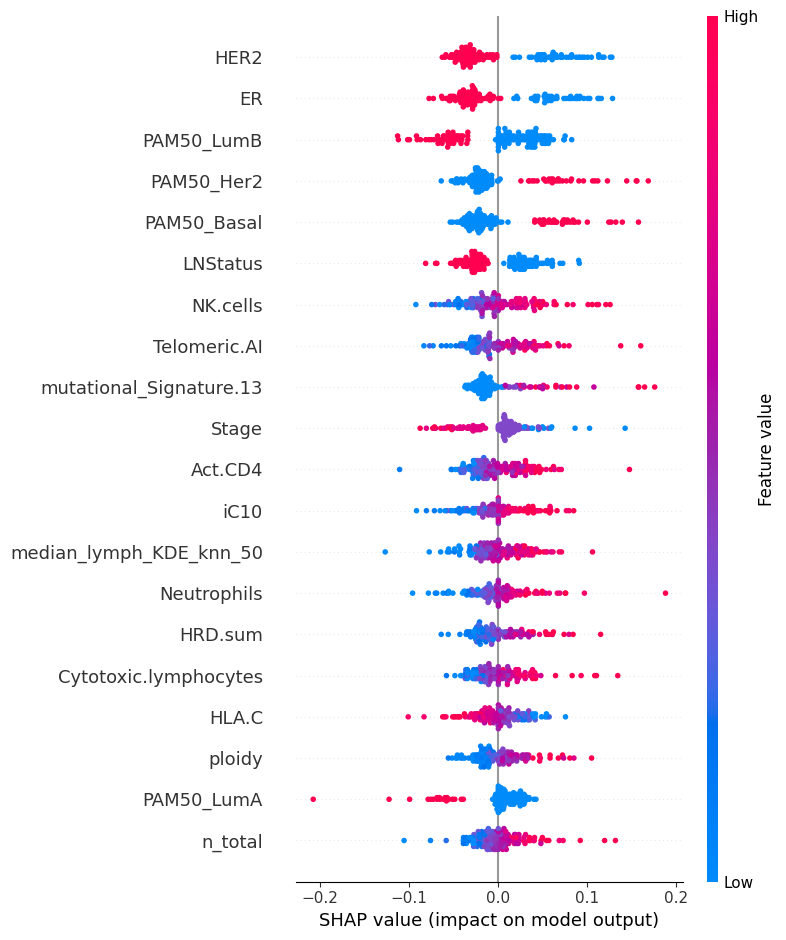

In [53]:
shap.summary_plot(svm_shap_values, X,feature_names=d3.columns)

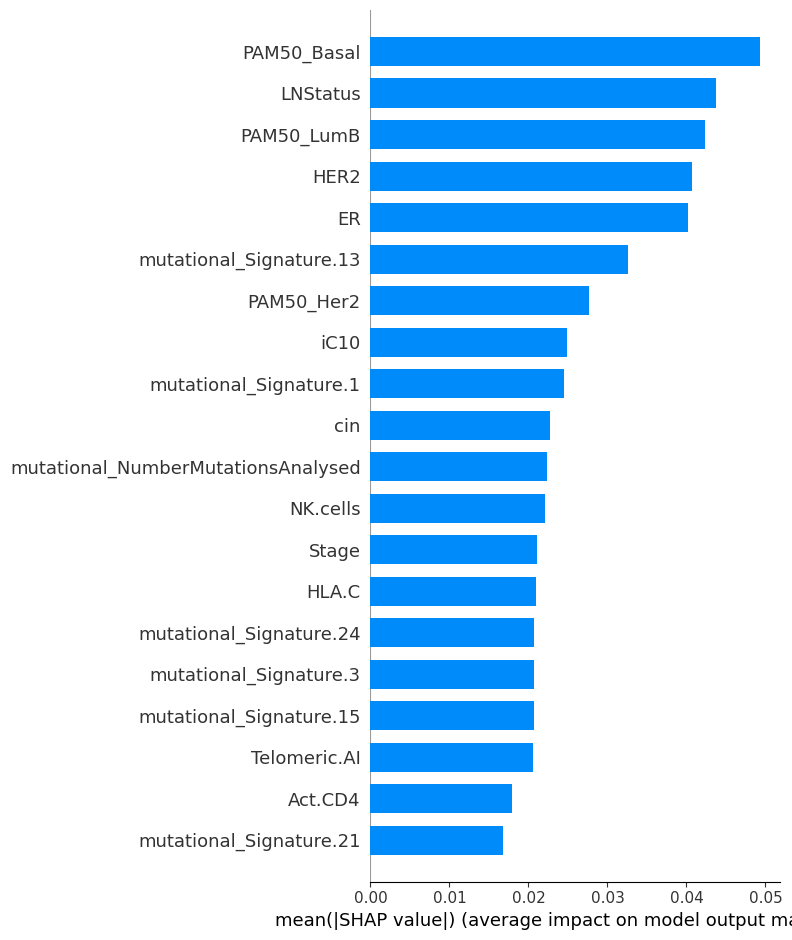

In [32]:
shap.summary_plot(svm_shap_values, X, feature_names=d3.columns, plot_type="bar")

# Individual Prediction

In [54]:
explainer = shap.KernelExplainer(clf.predict_proba, X, link="logit")
shap_values = explainer.shap_values(X, nsamples=149)

# plot the SHAP values for the Setosa output of the first instance
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X.iloc[0,:], link="logit")

Using 149 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 149/149 [02:08<00:00,  1.16it/s]


In [35]:
import numpy as np

# Assuming clf is your trained classifier and X is your data

probabilities = clf.predict_proba(X)[:, 1]  # Assuming you're interested in the second class (index 1)

# Step 2: Find indexes of the lowest and highest probabilities
# For the lowest probabilities
lowest_indexes = np.argsort(probabilities)[:10]  # Get indexes of the rows with the 10 lowest probabilities
# For the highest probabilities
highest_indexes = np.argsort(probabilities)[-10:][::-1]  # Get indexes of the rows with the 10 highest probabilities

# Step 3: Extract the rows from X
X_lowest = X.iloc[lowest_indexes]
X_highest = X.iloc[highest_indexes]

# Now X_lowest contains the rows with the lowest probabilities and X_highest contains those with the highest

In [62]:
import shap
import numpy as np

# Assuming clf is your trained classifier, X is your feature matrix,
# and you've already created the explainer as shown earlier

# Get prediction probabilities for the positive class (class 1)
probabilities = clf.predict_proba(X)[:, 1]

# Find indexes of the lowest and highest probabilities
lowest_index = np.argmin(probabilities)  # Index of the row with the lowest probability
highest_index = np.argmax(probabilities)  # Index of the row with the highest probability

# Assuming you've calculated shap_values with:
# shap_values = explainer.shap_values(X, nsamples=149)

# Initialize JavaScript visualization in the notebook
shap.initjs()

# Plot for the instance with the lowest probability
print("Force plot for the instance with the lowest probability:")
shap.force_plot(explainer.expected_value[1], shap_values[1][lowest_index,:], X.iloc[lowest_index,:], link="logit")

Force plot for the instance with the lowest probability:


In [63]:

# Plot for the instance with the highest probability
print("Force plot for the instance with the highest probability:")
shap.force_plot(explainer.expected_value[1], shap_values[1][highest_index,:], X.iloc[highest_index,:], link="logit")

Force plot for the instance with the highest probability:


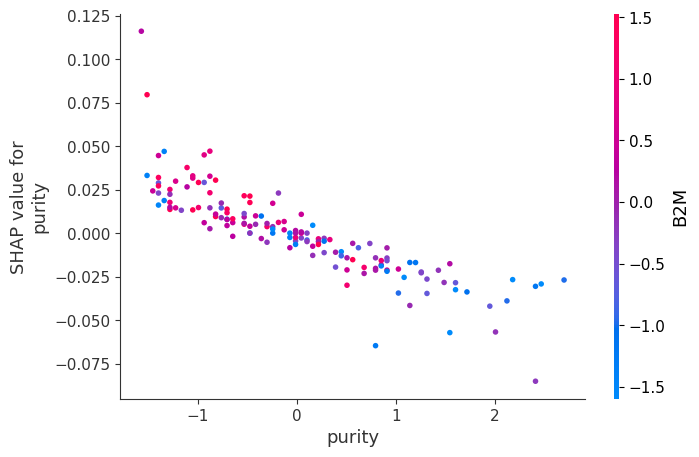

In [61]:
shap.dependence_plot(0, svm_shap_values,X, feature_names=d3.columns)

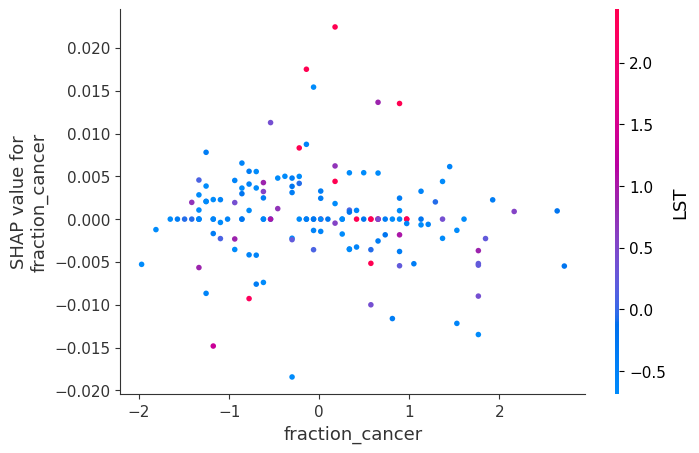

In [60]:
shap.dependence_plot(4, svm_shap_values,X, feature_names=d3.columns)